# 二维圆柱绕流

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_navier_stokes2D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_navier_stokes2D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/physics_driven/navier_stokes2D.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。

## 概述

圆柱绕流，即二维圆柱低速非定常绕流，流动特性与雷诺数`Re`有关。。在`Re`≤1时，流场中的惯性力与粘性力相比居次要地位，圆柱上下游的流线前后对称，阻力系数近似与`Re`成反比，此`Re`数范围的绕流称为斯托克斯区；随着Re的增大，圆柱上下游的流线逐渐失去对称性。这种特殊的现象反映了流体与物体表面相互作用的奇特本质，求解圆柱绕流则是流体力学中的经典问题。

由于控制方程纳维-斯托克斯方程（Navier-Stokes equation）难以得到泛化的理论解，使用数值方法对圆柱绕流场景下控制方程进行求解，从而预测流场的流动，成为计算流体力学中的样板问题。传统求解方法通常需要对流体进行精细离散化，以捕获需要建模的现象。因此，传统有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM）往往成本比较大。

物理启发的神经网络方法（Physics-informed Neural Networks），以下简称`PINNs`，通过使用逼近控制方程的损失函数以及简单的网络构型，为快速求解复杂流体问题提供了新的方法。本案例利用神经网络数据驱动特性，结合`PINNs`求解圆柱绕流问题。

## 问题描述

纳维-斯托克斯方程（Navier-Stokes equation），简称`N-S`方程，是流体力学领域的经典偏微分方程，在粘性不可压缩情况下，无量纲`N-S`方程的形式如下：

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \frac{1} {Re} (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \frac{1} {Re} (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

其中，`Re`表示雷诺数。

本案例利用PINNs方法学习位置和时间到相应流场物理量的映射，实现`N-S`方程的求解：

$$
(x, y, t) \mapsto (u, v, p)
$$

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 自适应损失的多任务学习。
4. 优化器。
5. NavierStokes2D。
6. 模型训练。
7. 模型推理及可视化

In [1]:
import time

import numpy as np

import mindspore
from mindspore import context, nn, ops, Tensor, jit, set_seed, load_checkpoint, load_param_into_net
from mindspore import dtype as mstype


下述`src`包可以在[applications/physics_driven/navier_stokes/cylinder_flow_continuous/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/navier_stokes/cylinder_flow_continuous/src)下载。

In [2]:
from mindflow.cell import MultiScaleFCSequential
from mindflow.loss import MTLWeightedLoss
from mindflow.pde import NavierStokes, sympy_to_mindspore
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, calculate_l2_error


set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config('cylinder_flow.yaml')
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

## 创建数据集

本案例对已有的雷诺数为100的标准圆柱绕流进行初始条件和边界条件数据的采样。对于训练数据集，构建平面矩形的问题域以及时间维度，再对已知的初始条件，边界条件采样；基于已有的流场中的点构造测试集。

下载训练与测试数据集： [physics_driven/flow_past_cylinder/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/flow_past_cylinder/dataset/) 。


In [4]:
# create training dataset
cylinder_flow_train_dataset = create_training_dataset(config)
cylinder_dataset = cylinder_flow_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                              shuffle=True,
                                                              prebatched_data=True,
                                                              drop_remainder=True)

# create test dataset
inputs, label = create_test_dataset(config["test_data_path"])

./flow_past_cylinder/dataset
get dataset path: ./flow_past_cylinder/dataset
check eval dataset length: (36, 100, 50, 3)


## 构建模型

本示例使用一个简单的全连接网络，深度为6层，激活函数是`tanh`函数。

In [5]:
coord_min = np.array(config["geometry"]["coord_min"] + [config["geometry"]["time_min"]]).astype(np.float32)
coord_max = np.array(config["geometry"]["coord_max"] + [config["geometry"]["time_max"]]).astype(np.float32)
input_center = list(0.5 * (coord_max + coord_min))
input_scale = list(2.0 / (coord_max - coord_min))
model = MultiScaleFCSequential(in_channels=config["model"]["in_channels"],
                               out_channels=config["model"]["out_channels"],
                               layers=config["model"]["layers"],
                               neurons=config["model"]["neurons"],
                               residual=config["model"]["residual"],
                               act='tanh',
                               num_scales=1,
                               input_scale=input_scale,
                               input_center=input_center)


## 自适应损失的多任务学习

同一时间，基于PINNs的方法需要优化多个loss，给优化过程带来的巨大的挑战。我们采用*Kendall, Alex, Yarin Gal, and Roberto Cipolla. "Multi-task learning using uncertainty to weigh losses for scene geometry and semantics." CVPR, 2018.* 论文中提出的不确定性权重算法动态调整权重。

In [6]:
mtl = MTLWeightedLoss(num_losses=cylinder_flow_train_dataset.num_dataset)

## 优化器

In [7]:
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)
    load_param_into_net(mtl, param_dict)

# define optimizer
params = model.trainable_params() + mtl.trainable_params()
optimizer = nn.Adam(params, config["optimizer"]["initial_lr"])

## NavierStokes2D

下述`NavierStokes2D`将圆柱绕流问题同数据集关联起来，包含3个部分：控制方程，边界条件和初始条件。

In [8]:
class NavierStokes2D(NavierStokes):
    def __init__(self, model, re=100, loss_fn=nn.MSELoss()):
        super(NavierStokes2D, self).__init__(model, re=re, loss_fn=loss_fn)
        self.ic_nodes = sympy_to_mindspore(self.ic(), self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)

    def bc(self):
        bc_u = self.u
        bc_v = self.v
        equations = {"bc_u": bc_u, "bc_v": bc_v}
        return equations

    def ic(self):
        ic_u = self.u
        ic_v = self.v
        ic_p = self.p
        equations = {"ic_u": ic_u, "ic_v": ic_v, "ic_p": ic_p}
        return equations

    def get_loss(self, pde_data, bc_data, bc_label, ic_data, ic_label):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, Tensor(np.array([0.0]).astype(np.float32), mstype.float32))

        ic_res = self.parse_node(self.ic_nodes, inputs=ic_data)
        ic_residual = ops.Concat(1)(ic_res)
        ic_loss = self.loss_fn(ic_residual, ic_label)

        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_residual = ops.Concat(1)(bc_res)
        bc_loss = self.loss_fn(bc_residual, bc_label)

        return pde_loss + ic_loss + bc_loss



## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [9]:
def train():
    problem = NavierStokes2D(model)

    from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
    if use_ascend:
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')
    else:
        loss_scaler = None

    # the loss function receives 5 data sources: pde, ic, ic_label, bc and bc_label
    def forward_fn(pde_data, bc_data, bc_label, ic_data, ic_label):
        loss = problem.get_loss(pde_data, bc_data, bc_label, ic_data, ic_label)
        if use_ascend:
            loss = loss_scaler.scale(loss)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    # using jit function to accelerate training process
    @jit
    def train_step(pde_data, bc_data, bc_label, ic_data, ic_label):
        loss, grads = grad_fn(pde_data, bc_data, bc_label, ic_data, ic_label)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)

        loss = ops.depend(loss, optimizer(grads))
        return loss


    epochs = config["train_epochs"]
    steps_per_epochs = cylinder_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, cylinder_dataset, sink_size=1)

    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs + 1):
            step_train_loss = sink_process()
        print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            # eval
            calculate_l2_error(model, inputs, label, config)


In [10]:
time_beg = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - time_beg))

momentum_x: u(x, y, t)*Derivative(u(x, y, t), x) + v(x, y, t)*Derivative(u(x, y, t), y) + Derivative(p(x, y, t), x) + Derivative(u(x, y, t), t) - 0.00999999977648258*Derivative(u(x, y, t), (x, 2)) - 0.00999999977648258*Derivative(u(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
momentum_y: u(x, y, t)*Derivative(v(x, y, t), x) + v(x, y, t)*Derivative(v(x, y, t), y) + Derivative(p(x, y, t), y) + Derivative(v(x, y, t), t) - 0.00999999977648258*Derivative(v(x, y, t), (x, 2)) - 0.00999999977648258*Derivative(v(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
continuty: Derivative(u(x, y, t), x) + Derivative(v(x, y, t), y)
    Item numbers of current derivative formula nodes: 2
ic_u: u(x, y, t)
    Item numbers of current derivative formula nodes: 1
ic_v: v(x, y, t)
    Item numbers of current derivative formula nodes: 1
bc_u: u(x, y, t)
    Item numbers of current derivative formula nodes: 1
bc_v: v(x, y, t)
    Item numbers of current der

epoch: 100 train loss: 0.093663074 epoch time: 865.762 ms
    predict total time: 311.9645118713379 ms
    l2_error, U:  0.3021394710211443 , V:  1.000814785933711 , P:  0.7896103436562808 , Total:  0.4195581394947756
epoch: 200 train loss: 0.051423326 epoch time: 862.246 ms
    predict total time: 22.994279861450195 ms
    l2_error, U:  0.17839493992645483 , V:  1.0002689685398058 , P:  0.7346766341097746 , Total:  0.34769129318171776
epoch: 300 train loss: 0.048922822 epoch time: 862.698 ms
    predict total time: 20.47276496887207 ms
    l2_error, U:  0.19347126434977727 , V:  0.9995530930847041 , P:  0.7544902230473761 , Total:  0.35548966915028823
epoch: 400 train loss: 0.045927174 epoch time: 864.443 ms
    predict total time: 21.65961265563965 ms
    l2_error, U:  0.1824223402341706 , V:  0.9989275825381772 , P:  0.7425240152913066 , Total:  0.3495656434506572
...
epoch: 11600 train loss: 0.00017444199 epoch time: 865.210 ms
    predict total time: 24.872541427612305 ms
    l2_e

## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。

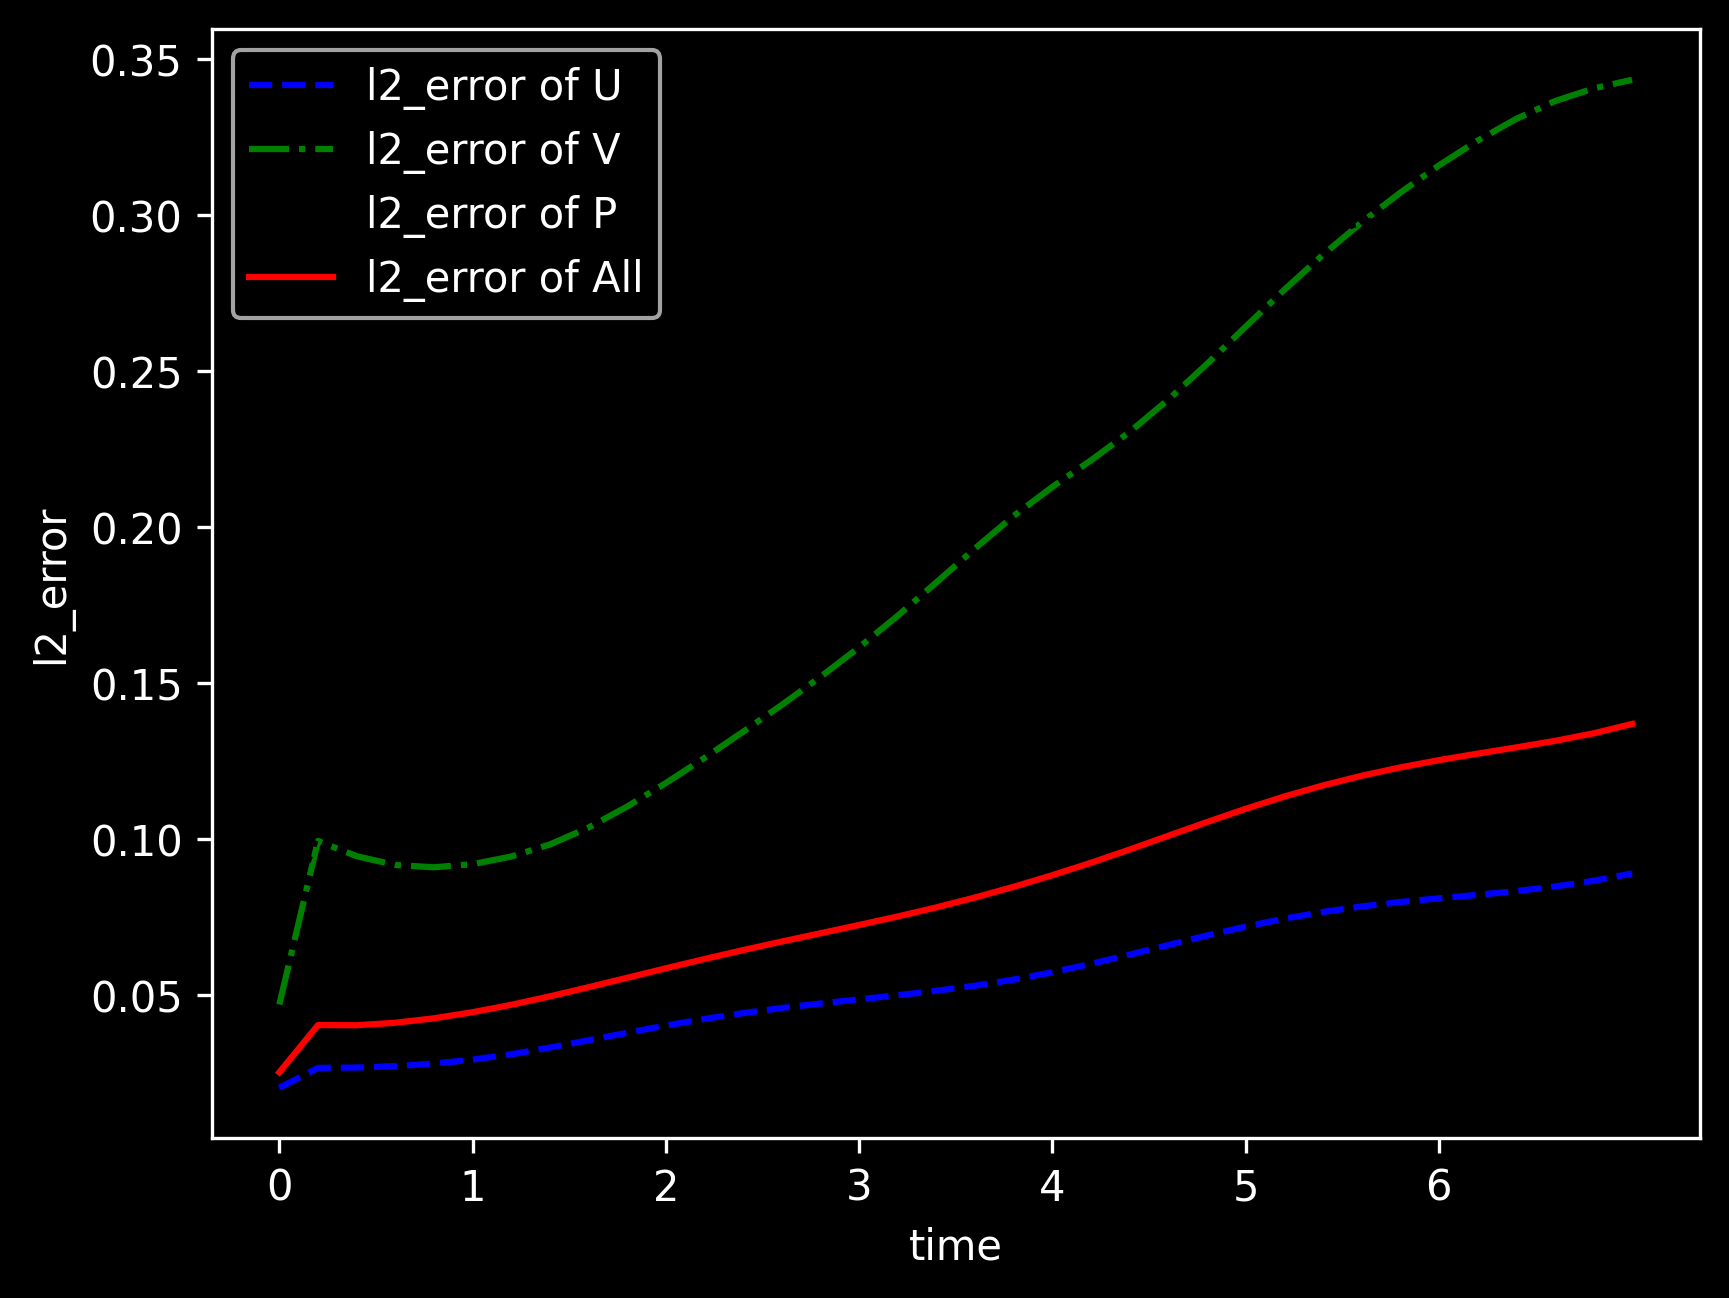

In [11]:
from src import visual

# visualization
visual(model=model, epochs=config["train_epochs"], input_data=inputs, label=label)